### TODO:

Train with extending windows 1960-X, to show if the forecast improves for later years.

Weigh average correctly


### Writeup

- Introduction 1000 words
 
- Background 4000

Rest for the corpus

- Methods (Data)

- Results and discussion
    - evolution of means of production
    - relevance of critics
    - climate change

These points must be present in the background search

In [332]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from tqdm.notebook import tqdm
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

plt.style.use('ggplot')
plt.rcParams['figure.figsize']= [15, 4]

df_st_em = pd.read_excel('data/generated_features_st_em.xlsx', index_col=0).loc[1961:2017]
df_medoc = pd.read_excel('data/generated_features_medoc.xlsx', index_col=0).loc[1961:2017]

display(df_medoc.head())

,Tm: debourrement - floraison,Tm: fleur,Tm: floraison - veraison,Tm: veraison - vendanges,Tm: vendanges,Wind: debourrement - floraison,Wind: fleur,Wind: floraison - veraison,Wind: veraison - vendanges,Wind: vendanges,...,Stress: vendanges,Growing Season Tm,Winter Rain,P: veraison - end vendanges,ETP: veraison - end vendanges,GDD10,Stress,Evap,Log price,Log price centered
1961,12.645588,14.573333,18.823529,19.543182,18.392857,216.5,48.5,214.7,118.7,75.9,...,-2.226786,2.052273,5.003289,106.9,207.5,2249.1,94.40,2.544385,7.321283,1.509740
1962,13.421429,18.350000,19.372131,18.642553,14.913636,214.2,21.3,189.5,148.6,62.4,...,-1.236364,3.085106,3.417763,94.7,176.8,2111.4,106.75,2.035612,6.324487,0.512944
1963,13.837313,17.250000,19.056140,16.883333,14.575000,219.5,30.8,146.1,158.1,71.8,...,-0.362500,6.152083,2.480921,171.8,151.9,1961.5,-146.10,4.241228,5.985195,0.173652
1964,14.382456,18.335714,19.865574,19.725000,15.126667,174.0,51.5,189.0,113.5,113.1,...,-6.405000,2.575000,1.697386,275.2,168.3,2232.2,100.05,3.281639,5.810285,-0.001258
1965,13.022368,18.800000,18.968085,16.259574,16.163158,276.4,48.0,143.8,174.8,62.3,...,-0.181579,6.525532,2.731579,254.1,132.7,1852.7,-167.10,3.738298,5.714393,-0.097150


In [333]:
def r_squared(x, y):
    return 1 - np.sum(np.square(x - y))/np.sum(np.square(x - np.mean(x)))

print(r_squared(np.array([1, 2, 3]), np.array([2,2,2])))

0.0


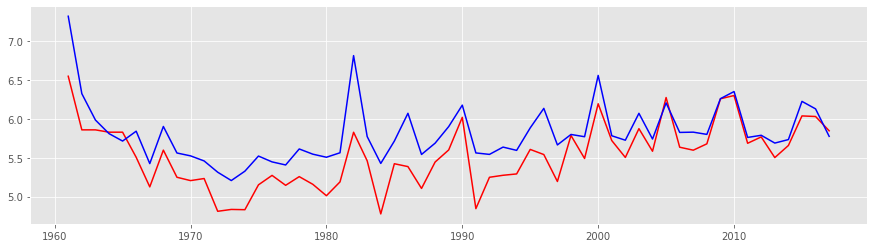

In [334]:
from sklearn.preprocessing import StandardScaler

X_st_em = df_st_em.drop('Log price', axis=1)

X_st_em = pd.DataFrame(StandardScaler().fit_transform(X_st_em), index=X_st_em.index, columns=X_st_em.columns).loc[1961:,:]

COLUMN_NAMES = X_st_em.columns.to_list()
y_st_em = df_st_em[['Log price']]
plt.plot(y_st_em, color = 'red')

X_medoc = df_medoc.drop('Log price', axis=1)

X_medoc = pd.DataFrame(StandardScaler().fit_transform(X_medoc), index=X_medoc.index, columns=X_medoc.columns).loc[1961:,:]

COLUMN_NAMES = X_medoc.columns.to_list()
y_medoc = df_medoc[['Log price']]
plt.plot(y_medoc, color = 'blue')

In [345]:
init_dict = {
    'Growing Season Tm':-0.1,
    #'Square Growing Season Tm':-0.1,
    'DTR: veraison - vendanges':0.2,
    'P: veraison - vendanges':-0.2,
    'Stress':0.2,
    'P: fleur':-0.1,
    'Wind: fleur':0.1,
    'Tm: floraison - veraison':0.1,
    'Floraison-veraison interval':-0.1,
    'Tx: debourrement - floraison':0.1,
    'DTR: debourrement - floraison':-0.1,
    'ETP: veraison - vendanges':0.1,
    'Dormancy':0.1,
}

class Regressive_Model_Combined(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length, model_features, bayesian = False):
        super().__init__()
        
        self.bayesian = bayesian
        self.weights = {}
        self.length = length
        self.type = {}
        self.weights_intercept_st_em = torch.nn.Parameter(torch.from_numpy(-0.3*np.ones(self.length)))
        self.weights_intercept_medoc = torch.nn.Parameter(torch.from_numpy(-0.3*np.ones(self.length)))

        self.walk_params = torch.nn.ParameterList([])
        for feature in model_features:
            if feature in init_dict.keys():
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(init_dict[feature]*np.ones(self.length))))
            else:
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(0.1*np.random.randn(self.length))))

        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in model_features]
        
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in []]
        
        if self.bayesian:
            self.intercept_st_em_logvar = torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length)))
            self.intercept_medoc_logvar = torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length)))

            self.walk_logvars = torch.nn.ParameterList([])
            for feature in GOOD_FEATURES:
                self.walk_logvars.append(torch.nn.Parameter(torch.from_numpy(-4*np.ones(self.length))))
        
            
    def sample_walks(self):
        walk_sample = []
        for i in range(len(self.walk_params)):
            walk_sample.append(self.walk_params[i] + torch.randn_like(self.walk_params[i]) * torch.exp(0.5 * self.walk_logvars[i])) # Element-wise multiplication of epsilon with variance
        return walk_sample

    
    
    def forward_st_em(self, X):
        """ 
        Forward pass of the model on one vintage for St Emilion
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept_st_em
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    def forward_st_em_bayesian(self, X):
        """ 
        Forward pass of the model on one vintage for St Emilion, bayesian sampling
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept_st_em + torch.randn_like(self.weights_intercept_st_em) * torch.exp(0.5 * self.intercept_st_em_logvar)
        
        walks = self.sample_walks()
        for i in range(len(walks)):
            result += walks[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    def forward_medoc(self, X):
        """ 
        Forward pass of the model on one vintage for Medoc
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept_medoc
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    def forward_medoc_bayesian(self, X):
        """ 
        Forward pass of the model on one vintage for St Emilion, bayesian sampling
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept_medoc + torch.randn_like(self.weights_intercept_medoc) * torch.exp(0.5 * self.intercept_medoc_logvar)
        
        walks = self.sample_walks()
        for i in range(len(walks)):
            result += walks[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    def loss_regularize_intercept(self):
        return torch.mean(torch.square(self.weights_intercept_st_em[1:] - self.weights_intercept_st_em[:-1]))\
    /torch.max(torch.abs(self.weights_intercept_st_em)) +\
            torch.mean(torch.square(self.weights_intercept_medoc[1:] - self.weights_intercept_medoc[:-1]))\
    /torch.max(torch.abs(self.weights_intercept_medoc))
    
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean(torch.square((t[1:] - t[:-1]))) / torch.max(torch.abs(t))
        return loss
    
    def loss_target_bayesian(self, X, y, zone):
        if zone == 'st_em':
            return torch.mean(torch.square(y - self.forward_st_em_bayesian(X)))
        else:
            return torch.mean(torch.square(y - self.forward_medoc_bayesian(X)))
            
    def loss_target(self, X, y, zone):
        if zone == 'st_em':
            return torch.mean(torch.square(y - self.forward_st_em(X)))
        else:
            return torch.mean(torch.square(y - self.forward_medoc(X)))
    
    
    def combined_loss(self, X, y, zone):
        return self.loss_target(X, y, zone) + 20* self.loss_regularize_walk_coeffs()\
                + 10*self.loss_regularize_intercept()

    def combined_loss_bayesian(self, X, y, zone):
        return self.loss_target_bayesian(X, y, zone) + 20* self.loss_regularize_walk_coeffs()\
                + 10*self.loss_regularize_intercept()
    
        
def training_loop_combined(model, optimizer, scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n)):
        loss = 0.5 * model.combined_loss(X_tensor_medoc, y_tensor_medoc, 'medoc') + 0.5 * model.combined_loss(X_tensor_st_em, y_tensor_st_em, 'st_em')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

def training_loop_combined_bayesian(model, optimizer, scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    size_X = list(X_tensor_medoc.size())
    size_y = list(y_tensor_st_em.size())
    for i in tqdm(range(n)):
        epsilon_X = 0.1*np.random.rand(*size_X)
        epsilon_y = 0.1*np.random.rand(*size_y)
        loss = 0.5 * model.combined_loss_bayesian(X_tensor_medoc + epsilon_X, y_tensor_medoc + epsilon_y, 'medoc') \
             + 0.5 * model.combined_loss_bayesian(X_tensor_st_em + epsilon_X, y_tensor_st_em + epsilon_y, 'st_em')
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

In [343]:
class Regressive_Model_Single(torch.nn.Module):
    """Optimizes over the whole given dataframe"""
    def __init__(self, init_dict, length, model_features):
        super().__init__()
        
        self.weights = {}
        self.length = length
        self.type = {}
        self.weights_intercept = torch.nn.Parameter(torch.from_numpy(-0.3*np.ones(self.length)))

        self.walk_params = torch.nn.ParameterList([])
        for feature in model_features:
            if feature in init_dict.keys():
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(init_dict[feature]*np.ones(self.length))))
            else:
                self.walk_params.append(torch.nn.Parameter(torch.from_numpy(0.1*np.random.randn(self.length))))

        self.where_to_find_walks = [COLUMN_NAMES.index(coeff_name) for coeff_name in model_features]
        
        self.where_to_find_scalars = [COLUMN_NAMES.index(coeff_name) for coeff_name in []]
        
    def forward(self, X):
        """ 
        Forward pass of the model on one vintage
        """
        result = torch.ones(self.length)*6
        result += self.weights_intercept
        for i in range(len(self.walk_params)):
            result += self.walk_params[i] * X[:,self.where_to_find_walks[i]]
        return result
    
    
    def loss_regularize_intercept(self):
        return torch.mean(torch.square(self.weights_intercept[1:] - self.weights_intercept[:-1]))\
    /torch.max(torch.abs(self.weights_intercept))
    
    
    def loss_regularize_walk_coeffs(self):
        loss = 0
        for t in self.walk_params:
            loss += torch.mean(torch.square(t[1:] - t[:-1])) / torch.max(torch.abs(t))
        return loss
    
    def loss_target(self, X, y):
        return torch.mean(torch.square(y - self.forward(X)))    
    
    def combined_loss(self, X, y):
        return self.loss_target(X, y) + 10* self.loss_regularize_walk_coeffs()\
                + 10*self.loss_regularize_intercept()
                #+ self.loss_keep_close_to_prior()
        
def training_loop_single(model, optimizer, scheduler, n=1000):
    "Training loop for torch model."
    losses = []
    for i in tqdm(range(n)):
        loss = model.combined_loss(X_tensor, y_tensor)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        losses.append(loss)  
    return losses

'Sun: veraison - vendanges' improves medoc R2 to .2

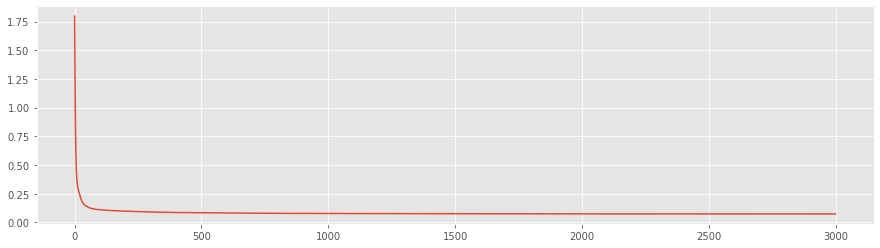

In [337]:
X_tensor_st_em = torch.FloatTensor(X_st_em.values)
y_tensor_st_em = torch.from_numpy(y_st_em['Log price'].values)
X_tensor_medoc = torch.FloatTensor(X_medoc.values)
y_tensor_medoc = torch.from_numpy(y_medoc['Log price'].values)

GOOD_FEATURES = ['Wind: fleur', 'Stress','DTR: veraison - vendanges', 'P: fleur', 'Sun: veraison - vendanges']

bayesian=False

model = Regressive_Model_Combined(init_dict, len(y_st_em), GOOD_FEATURES, bayesian=bayesian)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

if bayesian:
    losses = training_loop_combined_bayesian(model, optimizer, scheduler, 3000)
else:
    losses = training_loop_combined(model, optimizer, scheduler, 3000)
    
plt.plot(losses)
plt.show()

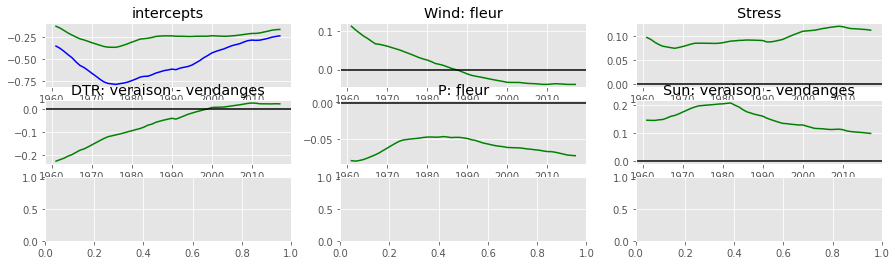

In [338]:
fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(1961, 2018), model.weights_intercept_st_em.detach().numpy(), color='blue')
subplot.plot(range(1961, 2018), model.weights_intercept_medoc.detach().numpy(), color='green')

subplot.set_title('intercepts')
for i in range(len(model.walk_params)):
    n = i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(1961, 2018), model.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[model.where_to_find_walks[i]])
plt.show()

#optimal_temp =  (- model.walk_params[0].detach().numpy() / (2*model.walk_params[1].detach().numpy()))*18 # x = -b/2a
#plt.plot(optimal_temp)

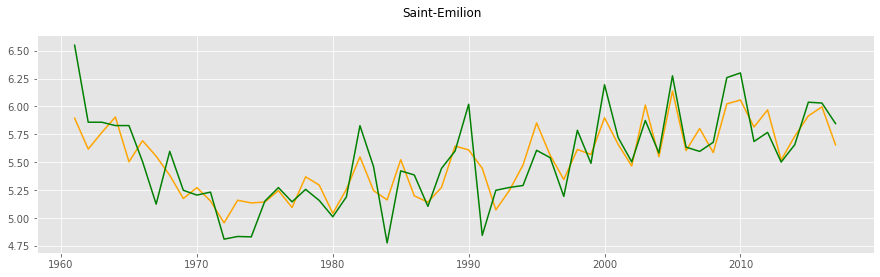

Spearman correlation between results and real log prices: 
 0.8852173913043477
R2 between results and real log prices: 
 0.49696216632945533


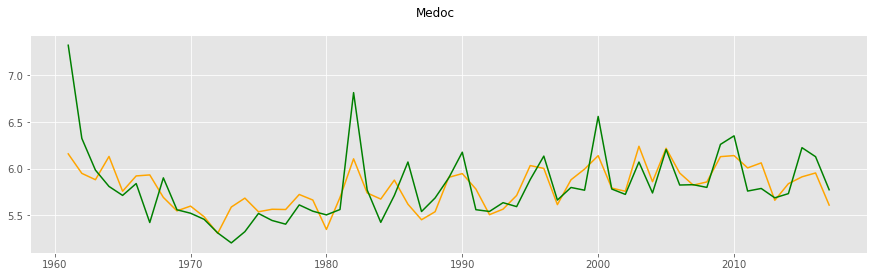

Spearman correlation between results and real log prices: 
 0.7426086956521739
R2 between results and real log prices: 
 0.042994991227427226

Combined:
Spearman correlation between results and real log prices: 
 0.7478260869565216
R2 between results and real log prices: 
 -0.1764171941555588


In [339]:
from scipy.stats import spearmanr
from sklearn.metrics import r2_score

full_predictions_st_em  = model.forward_st_em(X_tensor_st_em).detach().numpy()
predictions_st_em = full_predictions_st_em[33:]

plt.plot(range(1961, 2018), full_predictions_st_em, color='orange')
plt.plot(y_st_em['Log price'], color='g')
plt.suptitle('Saint-Emilion')
plt.show()
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions_st_em, y_st_em.loc[1994:, 'Log price']).correlation)
print('R2 between results and real log prices: \n', r2_score(predictions_st_em, y_st_em.loc[1994:, 'Log price']))

full_predictions_medoc  = model.forward_medoc(X_tensor_medoc).detach().numpy()
predictions_medoc = full_predictions_medoc[33:]
plt.plot(range(1961, 2018), full_predictions_medoc, color='orange')
plt.plot(y_medoc['Log price'], color='g')
plt.suptitle('Medoc')

plt.show()
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions_medoc, y_medoc.loc[1994:, 'Log price']).correlation)
print('R2 between results and real log prices: \n', r2_score(predictions_medoc, y_medoc.loc[1994:, 'Log price']))

predictions_combined = np.log(0.5 * np.exp(predictions_medoc) + 0.5 * np.exp(predictions_st_em))
mean_price = np.log(0.5*np.exp(y_st_em.loc[1994:2017, 'Log price'].values) + 0.5*np.exp(y_st_em.loc[1994:2017, 'Log price'].values))
print('\nCombined:')
print('Spearman correlation between results and real log prices: \n', spearmanr(predictions_combined, mean_price).correlation)
print('R2 between results and real log prices: \n', r2_score(predictions_combined, mean_price))

Best overall : with P: vendanges, 
>Spearman correlation between results and real log prices: 
> 0.8878260869565217
>
>R2 between results and real log prices: 
> 0.31347239989979714


Double one : ['Wind: fleur', 'Stress','DTR: veraison - vendanges', 'P: fleur', 'P: vendanges']

>Spearman correlation between results and real log prices: 
> 0.8791304347826084
> 
>R2 between results and real log prices: 
> 0.33702659011920744

# Ante 1994 model

Highlight the clear perf difference: continuing the line instead of just averaging the last coefficients gives a strong edge

In [ ]:
FIRST = 1961
LAST = 1993

X_tensor = torch.FloatTensor(X.loc[FIRST : LAST, :].values)
y_tensor = torch.from_numpy(y.loc[FIRST : LAST, 'Log price'].values)
GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur']

training_length = LAST - FIRST + 1
vintage_model_1994 = Regressive_Model(init_dict, training_length)
optimizer = torch.optim.Adam(vintage_model_1994.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)
losses = training_loop(vintage_model_1994, optimizer, scheduler, 4000)
plt.plot(losses)
plt.show()


GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur']

FIRST = 1961
LAST_2 = 2004
X_tensor = torch.FloatTensor(X.loc[FIRST : LAST_2, :].values)
y_tensor = torch.from_numpy(y.loc[FIRST : LAST_2, 'Log price'].values)
    
vintage_model_2005 = Regressive_Model(init_dict, LAST_2-FIRST+1)
optimizer = torch.optim.Adam(vintage_model_2005.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
losses = training_loop(vintage_model_2005, optimizer, scheduler, 4000)
plt.plot(losses)
plt.show()

In [14]:
def extrapolate_coeffs(model_coeffs_list, model_year_range, target_vintage):
    predicted_coeffs = []
    for coeffs in model_coeffs_list:
        line = LinearRegression()
        #line.fit(model_year_range, coeffs)
        line.fit(model_year_range[-15:], coeffs[-15:])
        
        predicted_coeffs.append(line.predict(np.array(target_vintage).reshape(1,-1)))
        #predicted_coeffs.append(np.mean(coeffs[-5:]))
    return predicted_coeffs

 
def predict_vintage(X, model, model_year_range, target_vintage):
    result = 6
    walk_params = [walk.detach().numpy() for walk in model.walk_params]
    model_extrapolated_walk_coeffs = extrapolate_coeffs(walk_params, model_year_range, target_vintage)
    model_extrapolated_intercept = extrapolate_coeffs([model.weights_intercept.detach().numpy()], model_year_range, target_vintage)[0]
    
    result += model_extrapolated_intercept

    for i in range(len(model_extrapolated_walk_coeffs)):
        result += model_extrapolated_walk_coeffs[i] * X[model.where_to_find_walks[i]]
    return result

In [ ]:
predictions=[]
for vintage in tqdm(range(1994, 2018)):
    predictions.append(predict_vintage(
        X.loc[vintage, :],
        vintage_model_1994,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage
                      ))
    
predictions_2=[]
for vintage in tqdm(range(2005, 2018)):
    predictions_2.append(predict_vintage(
        X.loc[vintage, :],
        vintage_model_2005,
        np.array(range(FIRST, LAST + 1)).reshape(-1,1),
        vintage
                      ))

In [ ]:

plt.plot(range(1994, 2018), predictions, color='red')
#plt.plot(range(2005, 2018), predictions_2, color='orange')

plt.plot(y.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions[:11], y.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions[11:], y.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period model 2\n', spearmanr(predictions_2, y.loc[2005:2017, 'Log price'].values).correlation)

print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions, y.loc[1994:2017, 'Log price'].values).correlation)
print('MAE  between results and real log prices: complete\n', np.mean(np.abs(predictions- y.loc[1994:, 'Log price'].values)), '\n')

print('Spearman correlation between results and real log prices: combined\n', spearmanr(predictions[:11]+predictions_2, y.loc[1994:2017, 'Log price'].values).correlation)
print('MAE  between results and real log prices: combined\n', np.mean(np.abs(predictions[:11]+predictions_2- y.loc[1994:2017, 'Log price'].values)), '\n')

print('R2 between results and real log prices: complete\n', r2_score(y.loc[1994:2017, 'Log price'].values, predictions))

fig, axs = plt.subplots(3,3)
subplot = axs[0, 0]
coeff = 'intercept'
subplot.plot(range(FIRST, LAST+1), vintage_model_1994.weights_intercept.detach().numpy(), color='green')
subplot.plot(range(FIRST, LAST_2+1), vintage_model_2005.weights_intercept.detach().numpy(), color='orange')
subplot.set_title('intercept')

for i in range(len(vintage_model_1994.walk_params)):
    n =  i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(FIRST, LAST + 1), vintage_model_1994.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[vintage_model_1994.where_to_find_walks[i]])
    
for i in range(len(vintage_model_2005.walk_params)):
    n = len(vintage_model_1994.walk_params) + i+1
    subplot = axs[n//3, n%3]

    subplot.plot(range(FIRST, LAST_2 + 1), vintage_model_2005.walk_params[i].detach().numpy(), color='green')
    subplot.axhline(0., color='black')
    subplot.set_title(COLUMN_NAMES[vintage_model_2005.where_to_find_walks[i]])

# Simple Regression : Saint Emilion

In [ ]:
#GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur']
GOOD_FEATURES = ['Wind: fleur', 'Stress','DTR: veraison - vendanges', 'P: fleur']
coefficients_df_st_em = pd.DataFrame(index = range(1994, 2018), columns = ['intercept st_em'] + GOOD_FEATURES)
next_coefficients_df_st_em = pd.DataFrame(index = range(1994, 2019), columns = ['intercept st_em'] + GOOD_FEATURES)
next_next_coefficients_df_st_em = pd.DataFrame(index = range(1994, 2020), columns = ['intercept st_em'] + GOOD_FEATURES)

for vintage in range(1994, 2018):
    print(vintage)
    FIRST = 1961
    LAST = vintage - 1
    
    X_tensor = torch.FloatTensor(X_st_em.loc[FIRST : LAST, :].values)
    y_tensor = torch.from_numpy(y_st_em.loc[FIRST : LAST, 'Log price'].values)
    
    training_length = LAST - FIRST + 1
        
    vintage_model = Regressive_Model_Single(init_dict, training_length, GOOD_FEATURES)
    
    optimizer = torch.optim.Adam(vintage_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=1)
    losses = training_loop_single(vintage_model, optimizer, scheduler, 3000)
    
    # Fill coefficients dataframe
    model_year_range = np.array(range(FIRST, LAST + 1)).reshape(-1,1)
    
    walk_params = [walk.detach().numpy() for walk in vintage_model.walk_params]
    
    coefficients_df_st_em.loc[vintage, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage)]
    next_coefficients_df_st_em.loc[vintage + 1, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 1)]
    next_next_coefficients_df_st_em.loc[vintage + 2, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 2)]

    coefficients_df_st_em.loc[vintage, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage)[0][0]
    next_coefficients_df_st_em.loc[vintage + 1, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 1)[0][0]
    next_next_coefficients_df_st_em.loc[vintage + 2, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 2)[0][0]

1994



1995



1996



1997



1998


In [222]:
pnew = 0.5
pold = 0.5

polder=0
predictions_st_em = []
for vintage in tqdm(range(1994, 2018)):    
    if vintage == 1994:
        prediction_st_em = 6 + coefficients_df_st_em.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction_st_em += coefficients_df_st_em.loc[vintage, feature] * X_st_em.loc[vintage, feature]
    
    elif vintage == 1995:
        prediction_st_em = 6 
        prediction_st_em += pnew * coefficients_df_st_em.loc[vintage, 'intercept st_em'] + pold * next_coefficients_df_st_em.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction_st_em += (pnew * coefficients_df_st_em.loc[vintage, feature] + pold * next_coefficients_df_st_em.loc[vintage, feature]) * X_st_em.loc[vintage, feature]
    else:
        prediction_st_em = 6 
        prediction_st_em += pnew * coefficients_df_st_em.loc[vintage, 'intercept st_em'] + pold * next_coefficients_df_st_em.loc[vintage, 'intercept st_em'] + polder * next_next_coefficients_df_st_em.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction_st_em += (pnew * coefficients_df_st_em.loc[vintage, feature] + pold * next_coefficients_df_st_em.loc[vintage, feature]+ polder * next_next_coefficients_df_st_em.loc[vintage, feature]) * X_st_em.loc[vintage, feature]

    predictions_st_em.append(prediction_st_em)

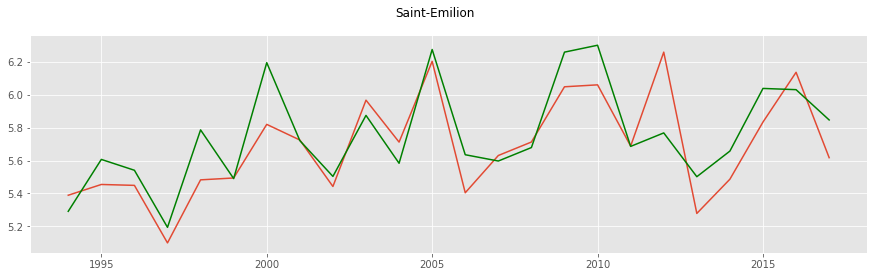

Spearman correlation between results and real log prices: first period
 0.8272727272727273
Spearman correlation between results and real log prices: second period
 0.7582417582417583
Spearman correlation between results and real log prices: complete
 0.826086956521739 

MAE  between results and real log prices: complete
 0.15216570262843912 

R2 between results and real log prices: complete
 0.5671482453612441


In [223]:
plt.plot(range(1994, 2018), predictions_st_em)
plt.suptitle('Saint-Emilion')
plt.plot(y_st_em.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions_st_em[:11], y_st_em.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions_st_em[11:], y_st_em.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions_st_em, y_st_em.loc[1994:2017, 'Log price'].values).correlation, '\n')

print('MAE  between results and real log prices: complete\n', np.mean(np.abs(predictions_st_em- y_st_em.loc[1994:, 'Log price'].values)), '\n')

print('R2 between results and real log prices: complete\n', r2_score(y_st_em.loc[1994:2017, 'Log price'].values, predictions_st_em))

### Simple Regression : Medoc

In [250]:
GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind:fleur']
coefficients_df_medoc = pd.DataFrame(index = range(1994, 2018), columns = ['intercept medoc'] + GOOD_FEATURES)
next_coefficients_df_medoc = pd.DataFrame(index = range(1994, 2019), columns = ['intercept medoc'] + GOOD_FEATURES)
next_next_coefficients_df_medoc = pd.DataFrame(index = range(1994, 2020), columns = ['intercept medoc'] + GOOD_FEATURES)

for vintage in range(1994, 2018):
    print(vintage)
    FIRST = 1961
    LAST = vintage - 1
    
    X_tensor = torch.FloatTensor(X_medoc.loc[FIRST : LAST, :].values)
    y_tensor = torch.from_numpy(y_medoc.loc[FIRST : LAST, 'Log price'].values)
    
    training_length = LAST - FIRST + 1
        
    vintage_model = Regressive_Model_Single(init_dict, training_length, GOOD_FEATURES)
    
    optimizer = torch.optim.Adam(vintage_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
    losses = training_loop_single(vintage_model, optimizer, scheduler, 3000)
    
    # Fill coefficients dataframe
    model_year_range = np.array(range(FIRST, LAST + 1)).reshape(-1,1)
    
    walk_params = [walk.detach().numpy() for walk in vintage_model.walk_params]
    
    coefficients_df_medoc.loc[vintage, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage)]
    next_coefficients_df_medoc.loc[vintage + 1, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 1)]
    next_next_coefficients_df_medoc.loc[vintage + 2, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 2)]

    coefficients_df_medoc.loc[vintage, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage)[0][0]
    next_coefficients_df_medoc.loc[vintage + 1, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 1)[0][0]
    next_next_coefficients_df_medoc.loc[vintage + 2, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept.detach().numpy()], model_year_range, vintage + 2)[0][0]

1994



1995



1996



1997



1998



1999



2000



2001



2002



2003



2004



2005



2006



2007



2008



2009



2010



2011



2012



2013



2014



2015



2016



2017


In [251]:
pnew = 1
pold = 0
predictions_medoc = []
print(coefficients_df_medoc.columns)
for vintage in tqdm(range(1994, 2018)):   
    if vintage == 1994:
        prediction_medoc = 6 + coefficients_df_medoc.loc[vintage, 'intercept medoc']
        for feature in GOOD_FEATURES:
            prediction_medoc += coefficients_df_medoc.loc[vintage, feature] * X_medoc.loc[vintage, feature]
    
    else:
        prediction_medoc = 6 
        prediction_medoc += pnew * coefficients_df_medoc.loc[vintage, 'intercept medoc'] + pold * next_coefficients_df_medoc.loc[vintage, 'intercept medoc']
        for feature in GOOD_FEATURES:
            prediction_medoc += (pnew * coefficients_df_medoc.loc[vintage, feature] + pold * next_coefficients_df_medoc.loc[vintage, feature]) * X_medoc.loc[vintage, feature]
    
    predictions_medoc.append(prediction_medoc)

Index(['intercept medoc', 'Stress', 'DTR: veraison - vendanges', 'P: fleur'], dtype='object')


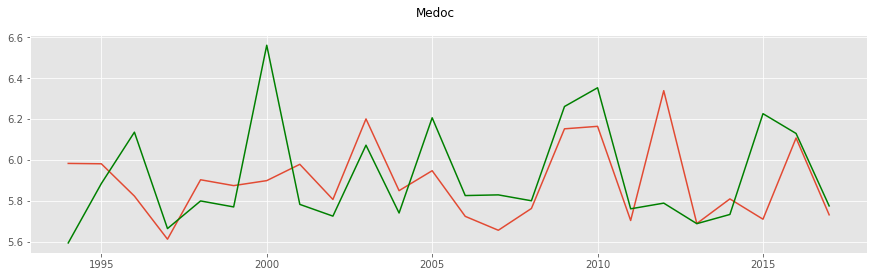

Spearman correlation between results and real log prices: first period
 0.24545454545454545
Spearman correlation between results and real log prices: second period
 0.4175824175824176
Spearman correlation between results and real log prices: complete
 0.38434782608695645 

MAE  between results and real log prices: complete
 0.18172734255923828 

R2 between results and real log prices: complete
 -0.030069128454095928


R2 between results and real log prices:
 0.10240999178181953
Spearman correlation between results and real log prices:
 0.7295652173913043 



In [252]:
plt.plot(range(1994, 2018), predictions_medoc)
plt.suptitle('Medoc')
plt.plot(y_medoc.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions_medoc[:11], y_medoc.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions_medoc[11:], y_medoc.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions_medoc, y_medoc.loc[1994:2017, 'Log price'].values).correlation, '\n')

print('MAE  between results and real log prices: complete\n', np.mean(np.abs(predictions_medoc- y_medoc.loc[1994:, 'Log price'].values)), '\n')

print('R2 between results and real log prices: complete\n', r2_score(y_medoc.loc[1994:2017, 'Log price'].values, predictions_medoc))

mean_pred = np.log(7*np.exp(predictions_st_em)/14 + 7*np.exp(predictions_medoc)/14)
mean_price = np.log(7/14*np.exp(y_st_em.loc[1994:2017, 'Log price'].values) + 7/14*np.exp(y_st_em.loc[1994:2017, 'Log price'].values))

print('\n\nR2 between results and real log prices:\n', r2_score(mean_pred, mean_price))
print('Spearman correlation between results and real log prices:\n', spearmanr(mean_pred, mean_price).correlation, '\n')

In [169]:
#coefficients_df_medoc[coefficients_df_medoc.columns] = coefficients_df_medoc.apply(lambda x: x.astype(float))
#coefficients_df_st_em[coefficients_df_st_em.columns] = coefficients_df_st_em.apply(lambda x: x.astype(float))
#coefficients_df_medoc.columns = ['Medoc: ' + col for col in coefficients_df_medoc.columns]
#coefficients_df_st_em.columns = ['St Em: ' + col for col in coefficients_df_st_em.columns]
#
#sns.lineplot(data = pd.concat((coefficients_df_medoc.iloc[:, 1:], coefficients_df_st_em.iloc[:, 1:]), axis = 0))
#
#plt.show()

# Combined regression : Medoc and Saint Emilion

In [359]:
GOOD_FEATURES = ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind: fleur']
coefficients_df = pd.DataFrame(index = range(1994, 2018), columns = ['intercept st_em', 'intercept medoc'] + GOOD_FEATURES)
next_coefficients_df = pd.DataFrame(index = range(1994, 2019), columns = ['intercept st_em', 'intercept medoc'] + GOOD_FEATURES)
next_next_coefficients_df = pd.DataFrame(index = range(1994, 2020), columns = ['intercept st_em', 'intercept medoc'] + GOOD_FEATURES)

for vintage in range(1994, 2018):
    print(vintage)
    FIRST = 1961
    LAST = vintage - 1
    
    X_tensor_st_em = torch.FloatTensor(X_st_em.loc[FIRST : LAST, :].values)
    y_tensor_st_em = torch.from_numpy(y_st_em.loc[FIRST : LAST, 'Log price'].values)
    X_tensor_medoc = torch.FloatTensor(X_medoc.loc[FIRST : LAST, :].values)
    y_tensor_medoc = torch.from_numpy(y_medoc.loc[FIRST : LAST, 'Log price'].values)
    
    training_length = LAST - FIRST + 1
        
    bayesian=False
    vintage_model = Regressive_Model_Combined(init_dict, training_length, GOOD_FEATURES, bayesian=bayesian)
    
    optimizer = torch.optim.Adam(vintage_model.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
    if bayesian:
        losses = training_loop_combined_bayesian(vintage_model, optimizer, scheduler, 2000)
    else:
        losses = training_loop_combined(vintage_model, optimizer, scheduler, 2000)
    
    # Fill coefficients dataframe
    model_year_range = np.array(range(FIRST, LAST + 1)).reshape(-1,1)
    
    walk_params = [walk.detach().numpy() for walk in vintage_model.walk_params]
    
    coefficients_df.loc[vintage, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage)]
    next_coefficients_df.loc[vintage + 1, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 1)]
    next_next_coefficients_df.loc[vintage + 2, GOOD_FEATURES] = [i[0] for i in extrapolate_coeffs(walk_params, model_year_range, vintage + 2)]

    coefficients_df.loc[vintage, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept_st_em.detach().numpy()], model_year_range, vintage)[0][0]
    next_coefficients_df.loc[vintage + 1, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept_st_em.detach().numpy()], model_year_range, vintage + 1)[0][0]
    next_next_coefficients_df.loc[vintage + 2, 'intercept st_em'] = extrapolate_coeffs([vintage_model.weights_intercept_st_em.detach().numpy()], model_year_range, vintage + 2)[0][0]
    
    coefficients_df.loc[vintage, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept_medoc.detach().numpy()], model_year_range, vintage)[0][0]
    next_coefficients_df.loc[vintage + 1, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept_medoc.detach().numpy()], model_year_range, vintage + 1)[0][0]
    next_next_coefficients_df.loc[vintage + 2, 'intercept medoc'] = extrapolate_coeffs([vintage_model.weights_intercept_medoc.detach().numpy()], model_year_range, vintage + 2)[0][0]

1994



1995



1996



1997



1998



1999



2000



2001



2002



2003



2004



2005



2006



2007



2008



2009



2010



2011



2012



2013



2014



2015



2016



2017


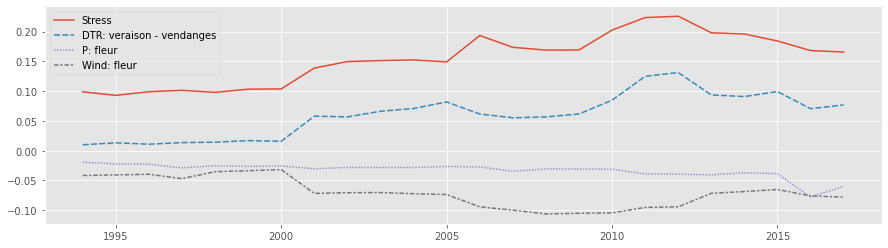

<AxesSubplot:>

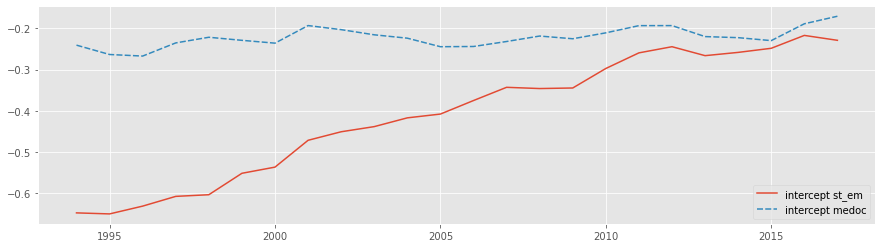

In [360]:
coefficients_df[coefficients_df.columns] = coefficients_df[coefficients_df.columns].apply(pd.to_numeric, errors='coerce', axis=1)

sns.lineplot(data = coefficients_df.iloc[:, 2:])
plt.show()

sns.lineplot(data=coefficients_df.iloc[:, :2])

In [361]:
pnew = 1
pold = 0

predictions_st_em = []
predictions_medoc = []

for vintage in tqdm(range(1994, 2018)):
    coefficients = coefficients_df.loc[(vintage-1):vintage, :].mean()
    
    if vintage == 1994:
        prediction_st_em = 6 + coefficients_df.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction_st_em += coefficients_df.loc[vintage, feature] * X_st_em.loc[vintage, feature]
    
    else:
        prediction_st_em = 6 
        prediction_st_em += pnew * coefficients_df.loc[vintage, 'intercept st_em'] + pold * next_coefficients_df.loc[vintage, 'intercept st_em']
        for feature in GOOD_FEATURES:
            prediction_st_em += (pnew * coefficients_df.loc[vintage, feature] + pold * next_coefficients_df.loc[vintage, feature]) * X_st_em.loc[vintage, feature]
    
    if vintage == 1994:
        prediction_medoc = 6 + coefficients_df.loc[vintage, 'intercept medoc']
        for feature in GOOD_FEATURES:
            prediction_medoc += coefficients_df.loc[vintage, feature] * X_medoc.loc[vintage, feature]
    
    else:
        prediction_medoc = 6 
        prediction_medoc += pnew * coefficients_df.loc[vintage, 'intercept medoc'] + pold * next_coefficients_df.loc[vintage, 'intercept medoc']
        for feature in GOOD_FEATURES:
            prediction_medoc += (pnew * coefficients_df.loc[vintage, feature] + pold * next_coefficients_df.loc[vintage, feature]) * X_medoc.loc[vintage, feature]
   
    predictions_st_em.append(prediction_st_em)
    predictions_medoc.append(prediction_medoc)

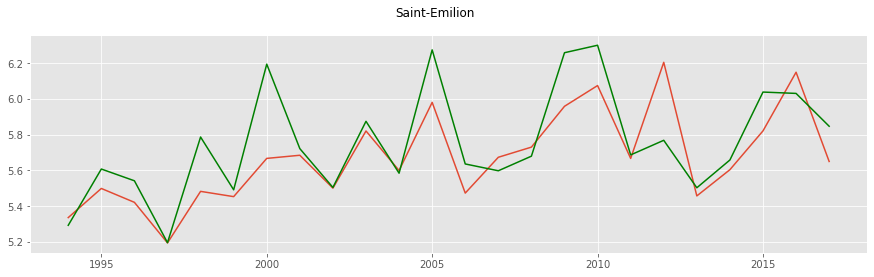

Spearman correlation between results and real log prices: first period
 0.8000000000000002
Spearman correlation between results and real log prices: second period
 0.7252747252747254
Spearman correlation between results and real log prices: complete
 0.8278260869565216 

MAE  between results and real log prices: complete
 0.14404431219634992 

R2 between results and real log prices: complete
 0.535517331723597


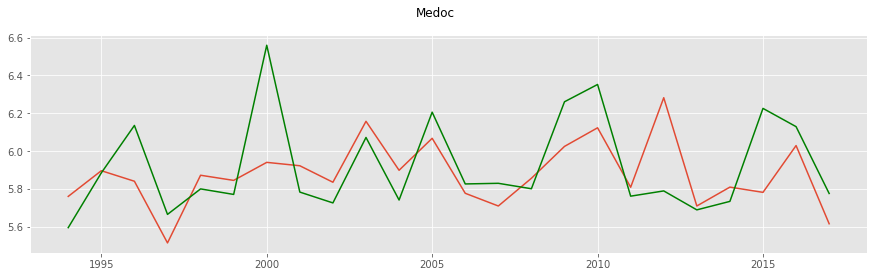

Spearman correlation between results and real log prices: first period
 0.6818181818181819
Spearman correlation between results and real log prices: second period
 0.42857142857142855
Spearman correlation between results and real log prices: complete
 0.5591304347826086 

MAE  between results and real log prices: complete
 0.16872282258329388 

R2 between results and real log prices: complete
 0.17112527136871936


R2 between results and real log prices:
 -0.018731331483704317
Spearman correlation between results and real log prices:
 0.797391304347826 



In [362]:
plt.plot(range(1994, 2018), predictions_st_em)
plt.suptitle('Saint-Emilion')
plt.plot(y_st_em.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions_st_em[:11], y_st_em.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions_st_em[11:], y_st_em.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions_st_em, y_st_em.loc[1994:2017, 'Log price'].values).correlation, '\n')

print('MAE  between results and real log prices: complete\n', np.mean(np.abs(predictions_st_em- y_st_em.loc[1994:, 'Log price'].values)), '\n')

print('R2 between results and real log prices: complete\n', r2_score(y_st_em.loc[1994:2017, 'Log price'].values, predictions_st_em))

plt.plot(range(1994, 2018), predictions_medoc)
plt.suptitle('Medoc')
plt.plot(y_medoc.loc[1994:2017, 'Log price'], color='g')
plt.show()
print('Spearman correlation between results and real log prices: first period\n', spearmanr(predictions_medoc[:11], y_medoc.loc[1994:2004, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: second period\n', spearmanr(predictions_medoc[11:], y_medoc.loc[2005:2017, 'Log price'].values).correlation)
print('Spearman correlation between results and real log prices: complete\n', spearmanr(predictions_medoc, y_medoc.loc[1994:2017, 'Log price'].values).correlation, '\n')

print('MAE  between results and real log prices: complete\n', np.mean(np.abs(predictions_medoc- y_medoc.loc[1994:, 'Log price'].values)), '\n')

print('R2 between results and real log prices: complete\n', r2_score(y_medoc.loc[1994:2017, 'Log price'].values, predictions_medoc))


mean_pred = np.log(0.5*np.exp(predictions_st_em) + 0.5*np.exp(predictions_medoc))
mean_price = np.log(0.5*np.exp(y_st_em.loc[1994:2017, 'Log price'].values) + 0.5*np.exp(y_st_em.loc[1994:2017, 'Log price'].values))

print('\n\nR2 between results and real log prices:\n', r2_score(mean_pred, mean_price))
print('Spearman correlation between results and real log prices:\n', spearmanr(mean_pred, mean_price).correlation, '\n')

Combined, with ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind: fleur']

>R2 between results and real log prices:
> 0.28574001347365874
>
>Spearman correlation between results and real log prices:
> 0.7347826086956522 

### ['Stress', 'DTR: veraison - vendanges', 'P: fleur', 'Wind: fleur'], Sur Saint Emilion

Avec aucun smoothing :

>Spearman correlation between results and real log prices: complete
> 0.8226086956521739 
>
>MAE  between results and real log prices: complete
> 0.18230644252901182 
>
>R2 between results and real log prices: complete
> 0.47


Avec smoothing : pas mieux



### Si on inclut le médoc :

St emilion :
>Spearman correlation between results and real log prices: complete
> 0.8391304347826085 
>
>MAE  between results and real log prices: complete
> 0.17323351327890332 
>
>R2 between results and real log prices: complete
> 0.44806926947875536
 
 
Medoc
>Spearman correlation between results and real log prices: complete
> 0.577391304347826 
>
>MAE  between results and real log prices: complete
> 0.19341179729260394 
>
>R2 between results and real log prices: complete
> -0.008350879562910585